<a href="https://colab.research.google.com/github/kumar6rishabh/Masked-RCNN-PyTorch-/blob/main/masked_rcnn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#

In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image , ImageDraw
from google.colab.patches import cv2_imshow

from torch import utils
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

--2022-09-03 06:21:32--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   159MB/s    in 0.3s    

2022-09-03 06:21:32 (159 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]



In [ ]:
!unzip *.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

In [ ]:
all_imgs = os.listdir("/content/PennFudanPed/PNGImages")

In [ ]:
class CustDat(torch.utils.data.Dataset):
  def __init__(self , transforms):
    self.transforms = transforms
    self.imgs = os.listdir(r"/content/PennFudanPed/PNGImages")
    self.masks = os.listdir(r"/content/PennFudanPed/PedMasks")
  def __getitem__(self , idx):
    name = self.imgs[idx]
    img = Image.open("/content/PennFudanPed/PNGImages/" + name).convert("RGB")
    mask = Image.open("/content/PennFudanPed/PedMasks/" + name[:-4] + "_mask.png")
    mask = np.array(mask)
    obj_ids = np.unique(mask)
    obj_ids = obj_ids[1:]
    masks = mask == obj_ids[: , None , None]
    num_objs = len(obj_ids)
    boxes = []

    for i in range(num_objs):
      y , x = np.where(mask == (i + 1))
      min_x , max_x = np.min(x) , np.max(x)
      min_y , max_y = np.min(y) , np.max(y)
      boxes.append([min_x , min_y , max_x , max_y])
    boxes = torch.tensor(boxes , dtype = torch.float32)
    labels = torch.ones((num_objs ,) , dtype = torch.int64)
    masks = torch.as_tensor(masks , dtype = torch.uint8)
    image_id = torch.tensor([idx])
    area = (boxes[: , 3] - boxes[: , 1]) * (boxes[: , 2] - boxes[: , 0])
    iscrowd = torch.zeros((num_objs , ) , dtype = torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img = self.transforms(img)
    return img , target

  def __len__(self):
    return len(self.imgs)

In [ ]:
dat = CustDat(None).__getitem__(2)

In [ ]:
image_id = dat[1]["image_id"].item()

In [ ]:
ig = dat[0]

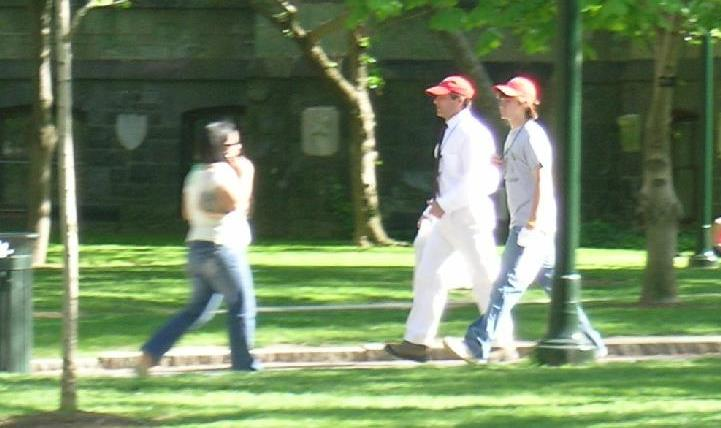

In [ ]:
ig

In [ ]:
bxs = dat[1]["boxes"][1]

In [ ]:
a , b , c , d = bxs.cpu().detach().numpy().astype("int")

In [ ]:
a , b , c , d

(386, 75, 515, 364)

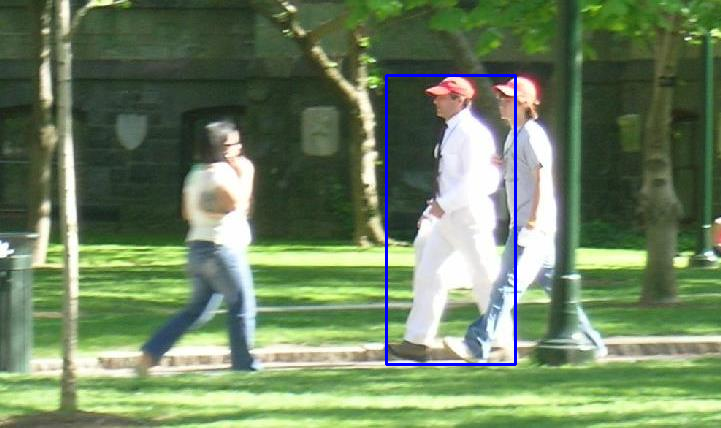

In [ ]:
ig = cv2.imread("/content/PennFudanPed/PNGImages/" + all_imgs[image_id])
ig = cv2.rectangle(np.array(ig) , (a, b) , (c , d) , (255 , 0 , 0) , 2)
cv2_imshow(ig)

In [ ]:
def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features , num_classes)
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , num_classes)
  return model

In [ ]:
def get_transform(train):
  transforms = []
  transforms.append(T.PILToTensor())
  transforms.append(T.ConvertImageDtype(torch.float))
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [ ]:
model = get_model_instance_segmentation(2)
dataset = CustDat(get_transform(False))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
def custom_collate(data):
  return data

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset , batch_size = 2 , shuffle = True , num_workers = 2 ,
                                          collate_fn = custom_collate)

In [ ]:
optimizer = torch.optim.SGD(model.parameters() , lr = 0.001 , momentum = 0.9 , weight_decay = 0.0005)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [ ]:
model.to(device)
num_epochs = 20
for epochs in range(num_epochs):
  epoch_loss = 0
  for data in data_loader:
    imgs = []
    target = []
    for d in data:
      imgs.append(d[0].to(device))
      targ = {}
      targ["boxes"] = d[1]["boxes"].to(device)
      targ["labels"] = d[1]["labels"].to(device)
      targ["masks"] = d[1]["masks"].to(device)
      targ["image_id"] = d[1]["image_id"].to(device)
      targ["area"] = d[1]["area"].to(device)
      targ["iscrowd"] = d[1]["iscrowd"].to(device)
      target.append(targ)
    loss_dict = model(imgs , target)

    loss = sum(val for val in loss_dict.values())
    epoch_loss += loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(epoch_loss)

51.150585278868675
23.798005431890488
20.200783506035805
18.24560998380184
17.016774341464043
15.944661982357502
15.055311053991318
14.631204605102539
13.976163633167744
13.652480818331242
13.19715329259634
12.960074223577976
12.561416186392307
12.183277077972889
11.973910577595234
11.767236702144146
11.421533301472664
11.327351868152618
11.140269666910172
11.106117896735668


In [ ]:
#inference
it = iter(data_loader).__next__()

In [ ]:
img = it[0][0].to(device)

In [ ]:
model.eval()
temp = model([img])
#img = img.cpu().detach().numpy()

In [ ]:
all_imgs = os.listdir("/content/PennFudanPed/PNGImages")

In [ ]:
idd = it[0][1]["image_id"].item()
fin_img = cv2.imread("/content/PennFudanPed/PNGImages/" + all_imgs[idd])

In [ ]:
temp

In [ ]:
boxes = temp[0]["boxes"].cpu().detach().numpy()

In [ ]:
g1 = boxes[1].astype("int")
#g2 = np.concatenate([boxes[0 , 2 : 4] , boxes[0 , 0 : 2]]).astype("int")

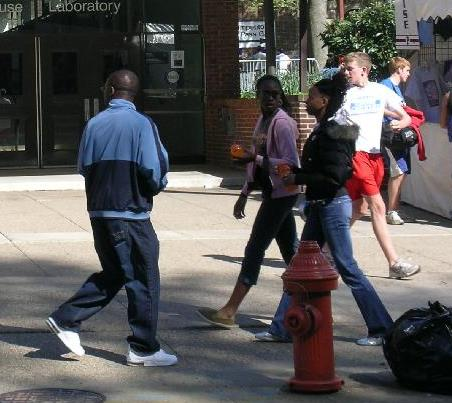

In [ ]:
cv2_imshow(fin_img)

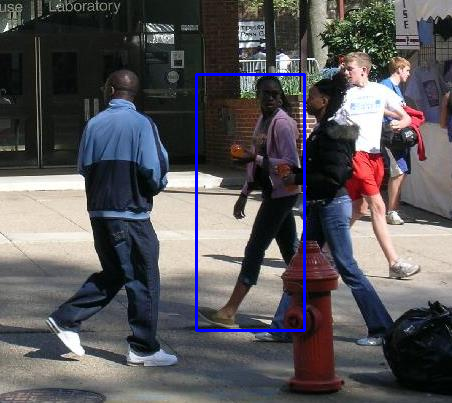

In [ ]:
ig = cv2.rectangle(fin_img , (g1[0] , g1[1]) , (g1[2] , g1[3]) , (255 , 0 , 0) , 2)
cv2_imshow(ig)

In [ ]:
mk = temp[0]["masks"][1]

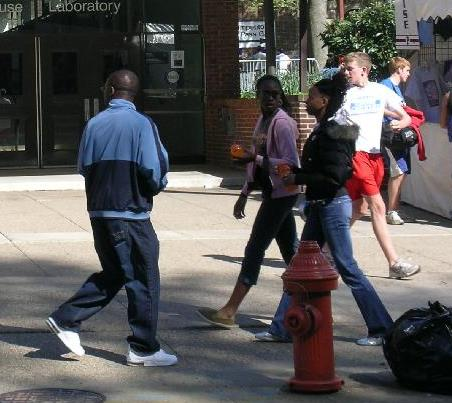

In [ ]:
fin_img = cv2.imread("/content/PennFudanPed/PNGImages/" + all_imgs[idd])
cv2_imshow(fin_img)

In [ ]:
fin_img.shape

(403, 452, 3)

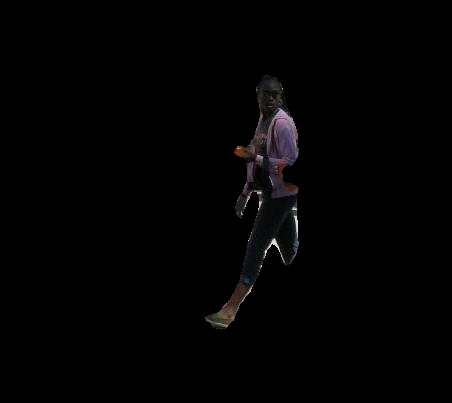

In [ ]:
cv2_imshow(np.where(mk.permute(1 , 2 , 0).cpu().detach().numpy() > 0.5, 1 , 0) * fin_img)